# First 10 Known-Pulsating Sources
- compare to original analysis
- now using spline detrending, which should speed up analysis
- only to do is to update summary table (will do shortly)

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

In [2]:
cross = Table.read('sourcefiles.csv')
summ = pd.read_csv('summtab.csv')

# First Source: Source #2 -- see Spline_Source2.ipynb
- just going to further investigation of possible non-radial pulsation between 6 and 7 days here
- non-radial pulsation at 6.79 days? above 95% false alarm

orbital period: 84.0


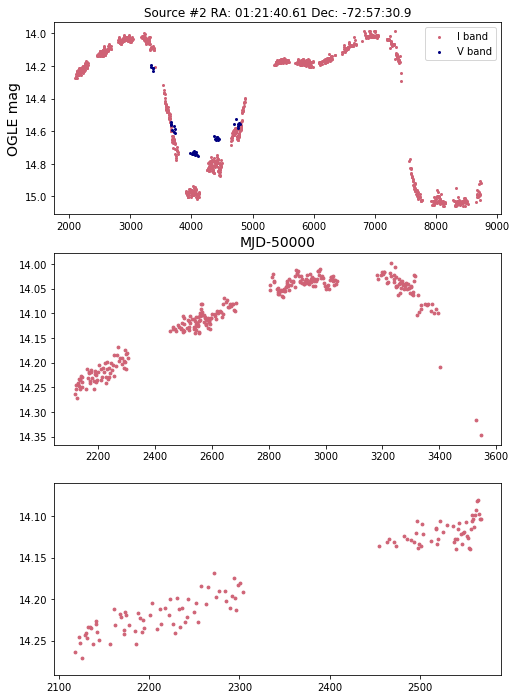

In [3]:
reload(o)
ilist,vlist = o.getIV(2,cross,plot=True,zooms=True,figsize=(8,12),mult=(3,8),offset=10,stack=False) #sometimes good to adjust offset
iband,vband = vstack(ilist),vstack(vlist)

In [11]:
def findbeat(p1,p2):
    '''Return beat period given two periods'''
    return 1/np.abs(1/p1 - 1/p2)
findbeat(6.79,84)

7.387126019945602

In [12]:
def aliasarr(arr,nrange=1,cutzero=True):
    '''Find aliases above 1 (or given value mina) using array of periods
    arr: array of period (peaks)
    nrange: maximum n to use in alias calculation
            n's used: -1*nrange to nrange'''
    n = np.arange(-1*nrange,nrange+1) #includes zero so returned array will include periods passed in
    #repeat range of n for # of periods passed in
    nt = np.tile(n,(len(arr),1))
    nt = np.swapaxes(nt,0,1)
    a = np.tile(arr,(len(n),1))
    farr = nt + 1/a 
    parr = np.abs(1/farr)
    #cut out array of original periods (from n=0)
    if cutzero:
        parr = np.concatenate([parr[:nrange],parr[nrange+1:]])
    return parr

In [5]:
#spline detrend
o.splinedetrend(iband,window=20,btol=20)

(14.42, 14.2)

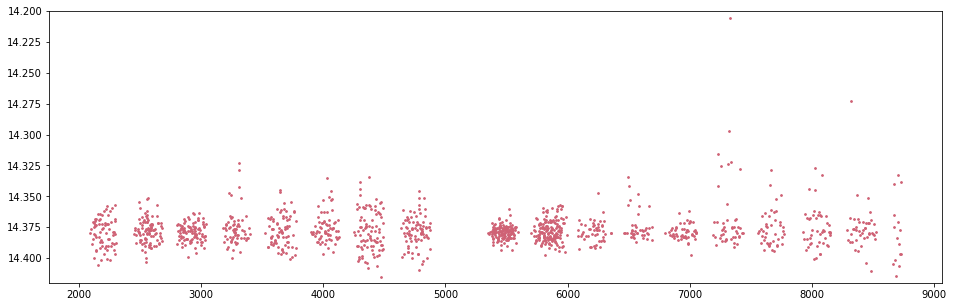

In [6]:
plt.figure(figsize=(16,5))
plt.scatter(iband['MJD-50000'],iband['I detrend'],color=pink,s=3)
plt.ylim(14.42,14.2)

<Quantity 6.80240637>

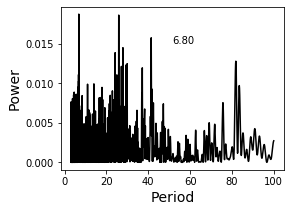

In [7]:
o.periodogram(iband,det=True,minp=3,maxp=100)

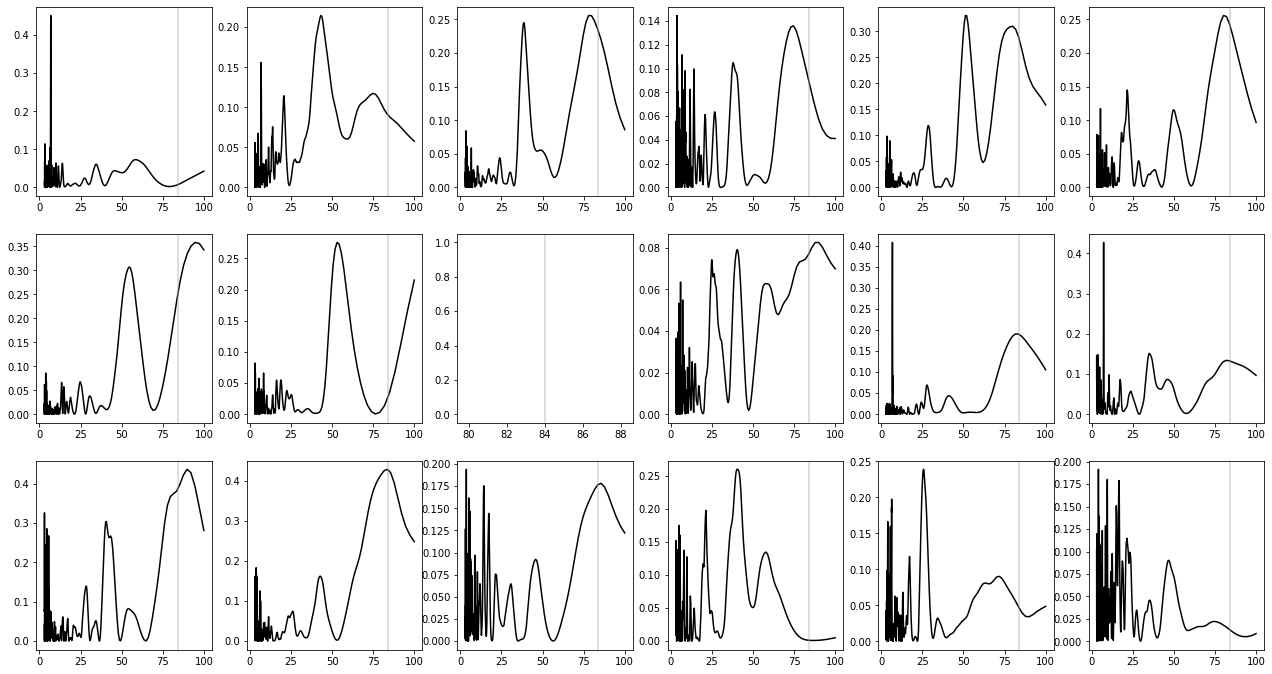

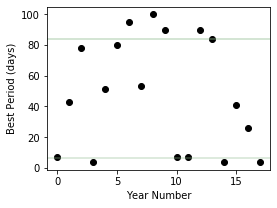

In [8]:
#strong suggesion of non-radial pulsations
yrs,bps = o.yrpd(iband,minp=3,maxp=100,orb=84,plotbest=True,det=True,window=100,plotpd=True,spline=True,btol=50)
plt.axhline(6.7,color='darkseagreen',alpha=0.4)

In [9]:
#rolling search (always an overlap)
ps,pows,bps,sts = o.rollpd(iband,npoint=200,nroll=20,det=True,minp=3,maxp=100,plot=False)

Text(0, 0.5, 'Best Period')

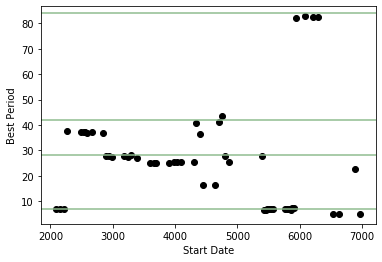

In [10]:
plt.scatter(sts,bps,color='black')
plt.axhline(83.99,color='darkseagreen')
plt.axhline(84/2,color='darkseagreen') #orbital period over 2
plt.axhline(84/3,color='darkseagreen') #orbital period over 3

plt.axhline(6.8,color='darkseagreen') #possible non-radial pulation -- pretty consistent
plt.xlabel('Start Date')
plt.ylabel('Best Period')

0.01845665454530744


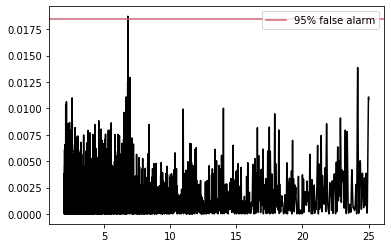

In [13]:
t = iband['MJD-50000']
y = iband['I detrend']
ls = LombScargle(t, y)
freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=1/25,
                           maximum_frequency=1/2,
                           samples_per_peak=50)
fl = ls.false_alarm_level(.05,method='bootstrap')
print(fl)
plt.plot(1/freq,power,color='black')
plt.axhline(fl,color=pink,label='95% false alarm')
plt.legend()

(14.4, 14.35)

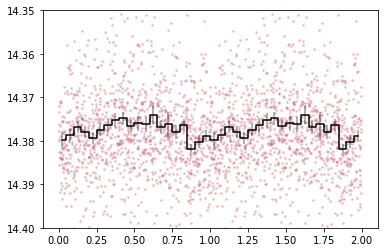

In [14]:
#fold with possible non-radial pulsations
#high standard error but good shape
mid,avg,err = o.meanphase(iband,6.79,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid')
plt.scatter((iband['MJD-50000']%6.79)/6.79,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.scatter(1+(iband['MJD-50000']%6.79)/6.79,iband['I detrend'],color=pink,s=3,alpha=0.3)

plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.ylim(14.4,14.35)

(14.385, 14.37)

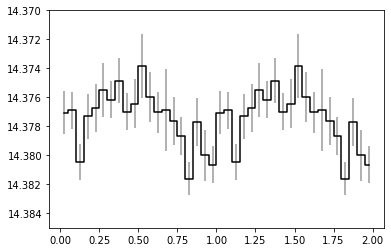

In [15]:
#without the points
mid,avg,err = o.meanphase(iband,6.79,pbins=20,det=True,med=False,double=True,stdev=True,epoch=-0.5,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid')
plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.ylim(14.385,14.37)

# Source 3
- previously agreed with established period
- important to follow-up since auto-analysis got best period 17.4

In [4]:
summ[2:3]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,V V-I int,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part
2,3,13.639167,-73.68364,2.37,0.8,18.38,0.259701,NaN,14.877813,0.267369,...,15.032918,yes,NaN,NaN,1.698965,2.086592,1.458121,0.808846,17.404354,1.0


orbital period: 18.38


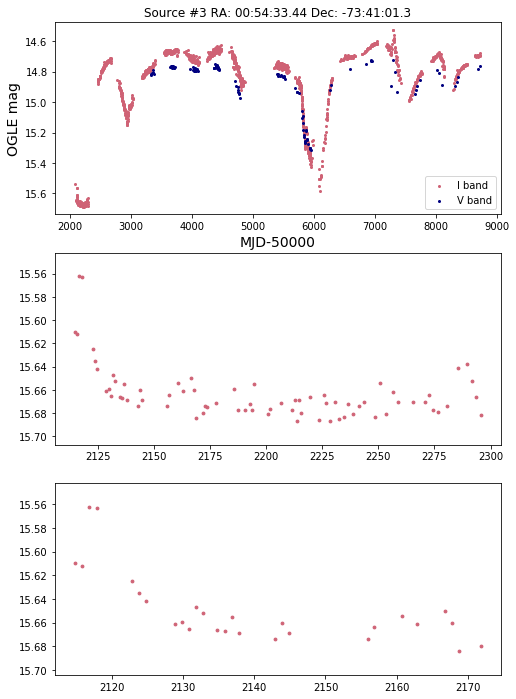

In [5]:
ilist,vlist = o.getIV(3,cross,plot=True,zooms=True,figsize=(8,12),mult=(3,8),offset=10,stack=False) #sometimes good to adjust offset
iband,vband = vstack(ilist),vstack(vlist)

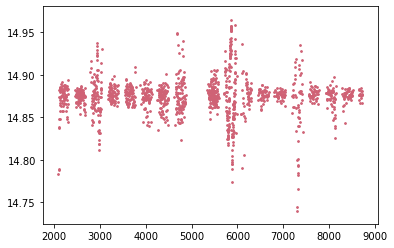

In [6]:
#spline detrend
o.splinedetrend(iband,window=300)
plt.scatter(iband['MJD-50000'],iband['I detrend'],color=pink,s=3)

(14.89, 14.86)

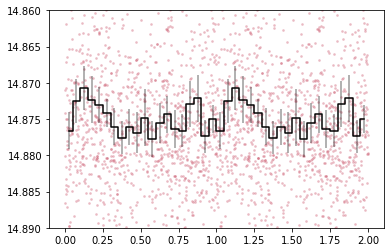

In [7]:
pd = 18.38
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid')
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)

plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.ylim(14.89,14.86)

(14.89, 14.86)

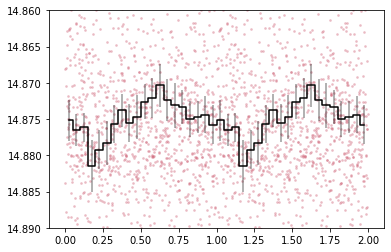

In [8]:
pd = 17.4 #from auto analysis
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid')
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)

plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.ylim(14.89,14.86)

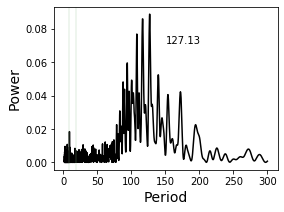

In [9]:
o.periodogram(iband,minp=2,maxp=300,det=True)
plt.axvline(18.38,alpha=0.2,color='darkseagreen')
plt.axvline(9.2,alpha=0.2,color='darkseagreen')

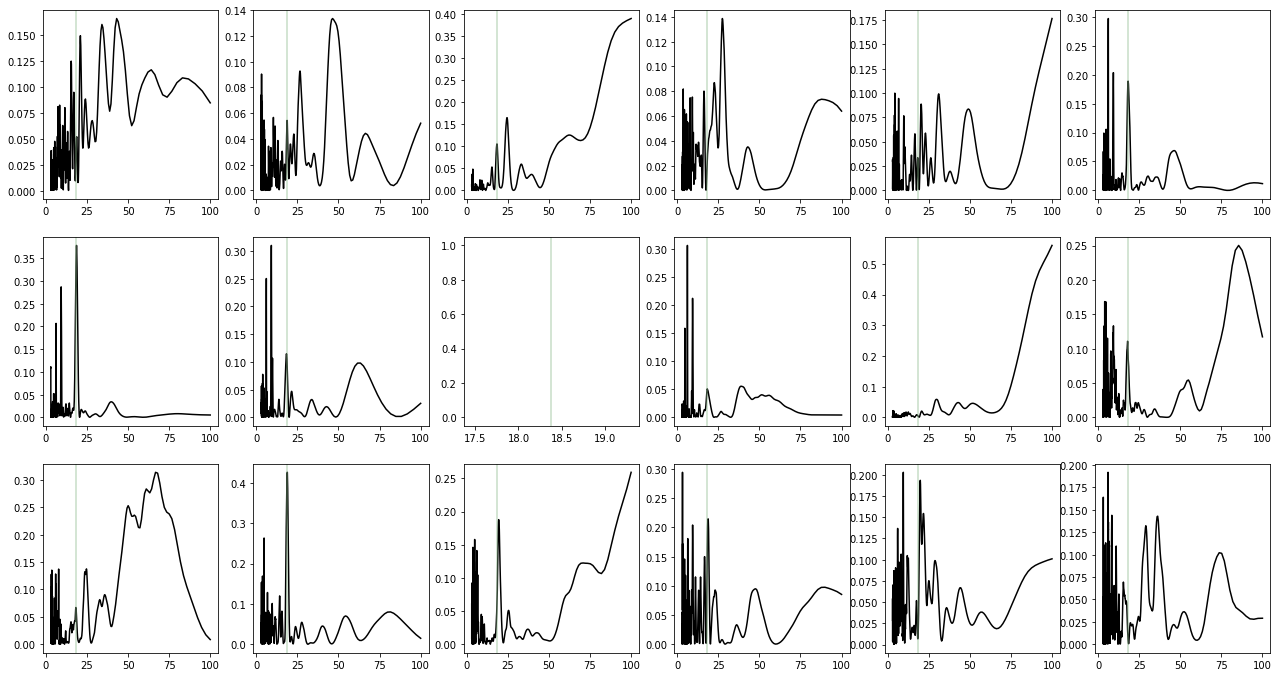

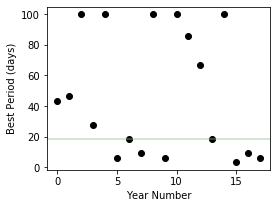

In [10]:
#search by year; spline detrended
yrs,bps = o.yrpd(iband,minp=3,maxp=100,orb=18.38,plotbest=True,det=True,window=100,plotpd=True,spline=True,btol=50)
# plt.axhline(6.7,color='darkseagreen',alpha=0.4)

In [17]:
#rolling period search
ps,pows,bps,sts = o.rollpd(iband,npoint=200,nroll=20,det=True,minp=3,maxp=40,plot=False)

Text(0, 0.5, 'Best Period')

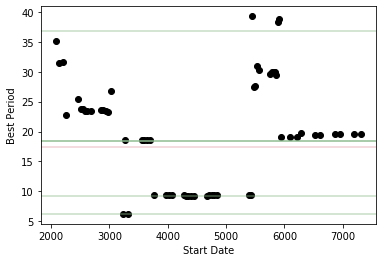

In [20]:
plt.scatter(sts,bps,color='black')
plt.axhline(18.38,color='darkseagreen')
plt.axhline(18.38/2,color='darkseagreen',alpha=0.5) #orbital period over 2
plt.axhline(18.38*2,color='darkseagreen',alpha=0.5) #orbital period times 2

plt.axhline(18.38/3,color='darkseagreen',alpha=0.5) #orbital period over 3
plt.axhline(17.4,color=pink,alpha=0.3) #detrended best p in region

plt.xlabel('Start Date')
plt.ylabel('Best Period')

In [19]:
bps

[35.20160225882728,
 31.515524664947804,
 31.59678321860459,
 22.806649716470517,
 25.46719543519159,
 23.771446712153782,
 23.69507983209545,
 23.486413903082568,
 23.378397394186027,
 23.515521060285835,
 23.59643742943665,
 23.62159799546623,
 23.45876255505229,
 23.312900081617126,
 26.839116121020904,
 6.227843873662135,
 18.60447531848476,
 6.220058121583381,
 18.546442166870396,
 18.57369649507745,
 18.598145030121863,
 18.614037678597096,
 9.333179860558383,
 9.333627716309863,
 9.318912840049316,
 9.30449443023007,
 9.29451584408197,
 9.288197156437992,
 9.285554535623703,
 9.278250642078943,
 9.287186252411358,
 9.170240548100885,
 9.302277064472415,
 9.30956581572824,
 9.307255628152815,
 9.319272145694928,
 9.320584541357151,
 9.299665063526403,
 39.278990810647755,
 27.37749942078499,
 27.575086139598135,
 30.931087420819647,
 30.23707491687345,
 29.67239417070075,
 29.93915746042104,
 29.96951178013876,
 29.906714717942037,
 29.376345256331252,
 38.40253804755005,
 38.876

rolling average and LC search in original notebook most in support of 18.38 days
- and above, see that rolling doesn't give 17.4 (which would be pink line)
- but also values often slightly higher than 18.38

#### check on ~120 day period

In [53]:
#search with different detrending windows
for i in np.arange(50,800,100):
    o.splinedetrend(iband,window=i)
    bp = o.periodogram(iband,minp=2,maxp=1000,det=True,plot=False)
    print(bp)

83.3845287558957
127.11922621866682
127.11922621866682
127.11922621866682
127.11922621866682
127.11922621866682
127.11922621866682
127.11922621866682


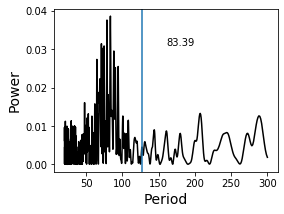

In [56]:
#plot periodogram with different result 
o.splinedetrend(iband,window=50)
bp = o.periodogram(iband,minp=20,maxp=300,det=True,plot=True)
plt.axvline(127)

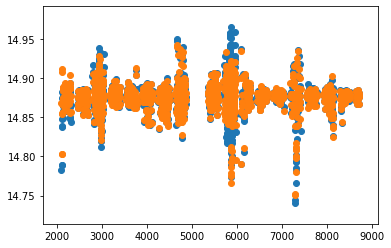

In [52]:
o.splinedetrend(iband,window=200)
plt.scatter(iband['MJD-50000'],iband['I detrend'])
o.splinedetrend(iband,window=50)
plt.scatter(iband['MJD-50000'],iband['I detrend'])

(14.95, 14.83)

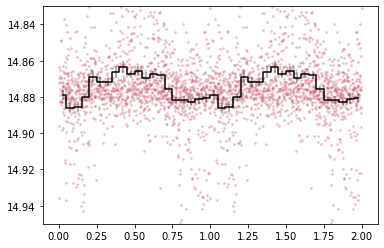

In [67]:
pd = 127.1 #from auto analysis
o.splinedetrend(iband,window=1000)

mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid')
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)

plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.ylim(14.95,14.83)

## dependent on detrending but searching in LC briefly
- close to a multiple of 18.38

In [72]:
18.38*7

128.66

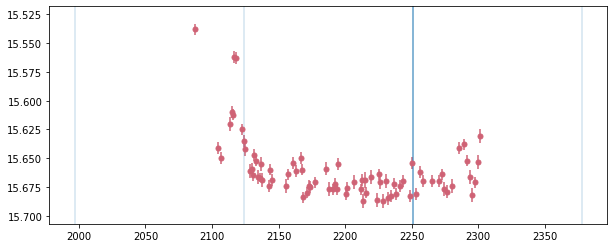

In [74]:
idays = iband['MJD-50000']
imag = iband['I mag']
ierr = iband['I mag err']

def checkorb(st,end,cen=2251,orb=127.1,plcen=False,figsize=(10,4)):
    stday = idays[st:st+1]
    enday = idays[end-1:end]
    fig = plt.figure(figsize=figsize)
    plt.errorbar(idays[st:end],imag[st:end],yerr=ierr[st:end],linestyle='none',marker='o',color=pink,markersize=5)
    maxi,mini = np.max(imag[st:end]),np.min(imag[st:end])
    plt.ylim(maxi+.02,mini-.02)

    fline = int((stday - cen)/orb)
    lline = int((enday - cen)/orb)
    for i in range(fline-1,lline+2):
        plt.axvline(cen+orb*i,alpha=0.2)
    if plcen: plt.axvline(cen,alpha=0.6)
checkorb(0,79,cen=2251,plcen=True)

#### went through LC (not detrended); not seeing evidence of 127 day period...

# Source 4
- auto detrended period off by less than a day but no distinguishable difference by-eye in phase-fold
- Source4.ipynb: also found that 81.9 better than established (using periodograms,LC crucially)
    - but still some problems in a subplot of LC
    - see rolling period search below -- drift?
- so mostly repeating below
- long established period given teh spin period

In [55]:
summ[3:4]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,V V-I int,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part
3,4,14.797429,-71.64596,2.763,7.5,82.37,0.0,NaN,13.919472,0.042264,...,14.04718,yes,0.03,doesn’t follow Corbet,1.061946,0.298944,0.799828,1.009136,81.891818,1.0


orbital period: 82.37


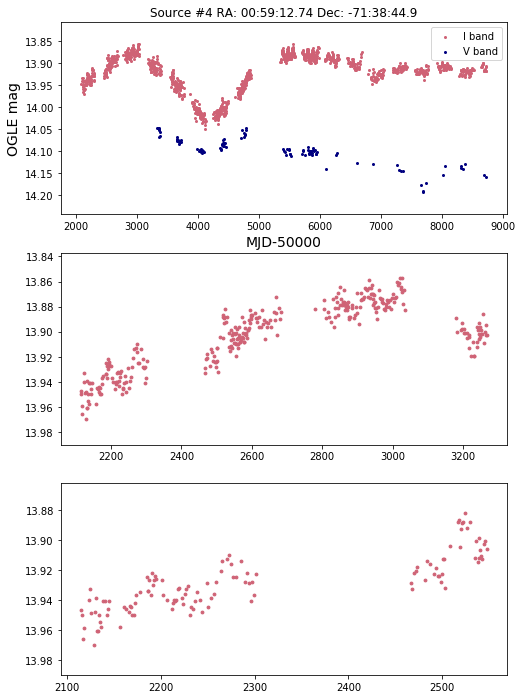

In [88]:
ilist,vlist = o.getIV(4,cross,plot=True,zooms=True,figsize=(8,12),mult=(3,8),offset=10,stack=False) #sometimes good to adjust offset
iband,vband = vstack(ilist),vstack(vlist)
o.splinedetrend(iband,window=100)

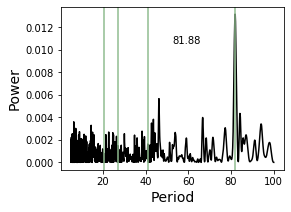

In [90]:
#without detrending; large search
bp = o.periodogram(iband,minp=5,maxp=100,det=False) 
plt.axvline(81.89,color='darkseagreen')
plt.axvline(81.89/2,color='darkseagreen')
plt.axvline(81.89/3,color='darkseagreen')
plt.axvline(81.89/4,color='darkseagreen')

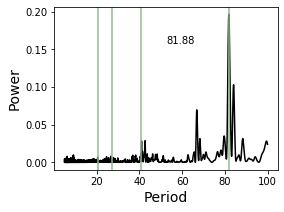

In [92]:
bp = o.periodogram(iband,minp=5,maxp=100,det=True) 
plt.axvline(81.89,color='darkseagreen')
plt.axvline(81.89/2,color='darkseagreen')
plt.axvline(81.89/3,color='darkseagreen')
plt.axvline(81.89/4,color='darkseagreen')

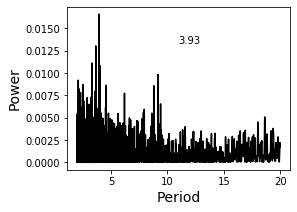

In [148]:
bp = o.periodogram(iband,minp=2,maxp=20,det=True) 


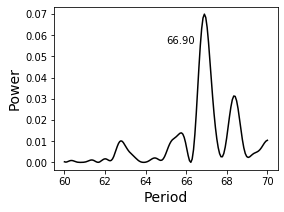

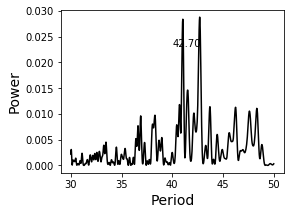

In [99]:
bp = o.periodogram(iband,minp=60,maxp=70,det=True) 
bp = o.periodogram(iband,minp=30,maxp=50,det=True) 

start ind: 0, end ind: -1


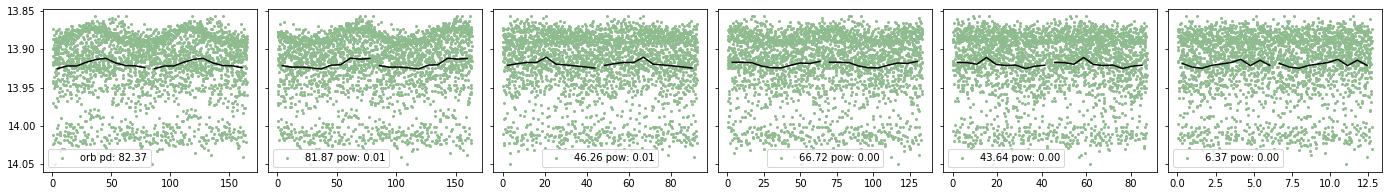

In [91]:
df,pks = o. multiphase(iband,st=0,end=-1,dense=False,orb=82.37,incl_orb=True,meanp=True,sigma=20,distance=30,minp=5,maxp=100,
               pbins=10,maxspace=20,plotpd=False,pkorder=True)

<ErrorbarContainer object of 3 artists>

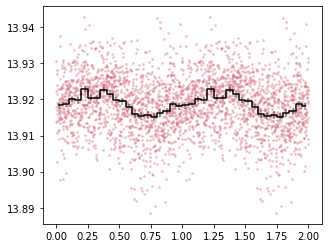

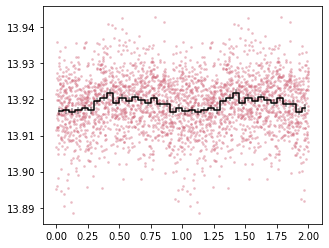

In [150]:
# detrended folding for smaller peaks in detrended periodogram
plt.figure(figsize=(5,4))
pd = 66.9
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid')
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)

plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
# plt.ylim(14.89,14.86)

plt.figure(figsize=(5,4))
pd = 42.7
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid')
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)

plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')

# plt.figure(figsize=(5,4))
# pd = 3.93
# mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
# plt.step(mid,avg,color='black',where='mid')
# plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
# plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)

# plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')

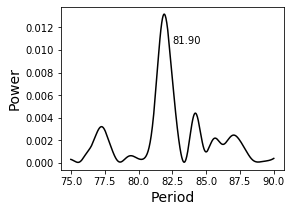

In [71]:
#without detrending
bp = o.periodogram(iband,minp=75,maxp=90,det=False,samples=100) #81.9 even at high samples

81.89755842357444
81.89379039420464


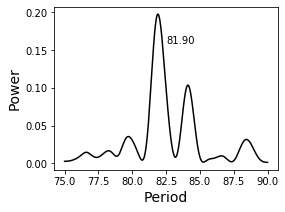

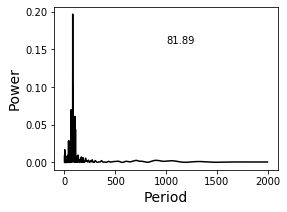

In [67]:
#periodogram with more samples
bp = o.periodogram(iband,minp=75,maxp=90,det=True,samples=100) #81.9 even at high samples
print(bp)
#~same answer with different bounds
bp = o.periodogram(iband,minp=2,maxp=2000,det=True,samples=100)
print(bp)

<ErrorbarContainer object of 3 artists>

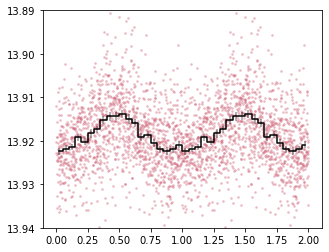

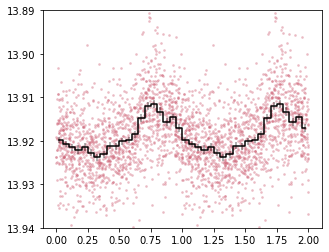

In [146]:
#compare folds
plt.figure(figsize=(5,4))
pd = 82.37 #established period
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid')
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)

plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.ylim(13.94,13.89)

#best period
plt.figure(figsize=(5,4))
pd = 81.89 #from auto analysis
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid')
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.ylim(13.94,13.89)

plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')

<ErrorbarContainer object of 3 artists>

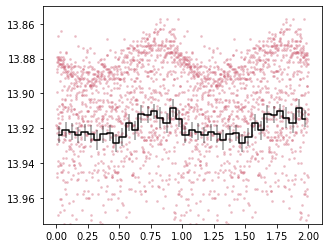

In [145]:
#just to see without detrending; cut out some with ylim
plt.figure(figsize=(5,4))
pd = 81.9 #from auto analysis
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=False,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid')
plt.scatter((iband['MJD-50000']%pd)/pd,iband['I mag'],color=pink,s=3,alpha=0.3)
plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I mag'],color=pink,s=3,alpha=0.3)
plt.ylim(13.975,13.85)
plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')

Text(0, 0.5, 'Best Period')

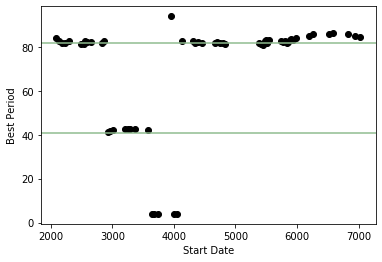

In [108]:
ps,pows,bps,sts = o.rollpd(iband,npoint=200,nroll=20,det=True,minp=3,maxp=100,plot=False)
plt.scatter(sts,bps,color='black')
plt.axhline(81.9,color='darkseagreen')
plt.axhline(81.9/2,color='darkseagreen')

plt.xlabel('Start Date')
plt.ylabel('Best Period')

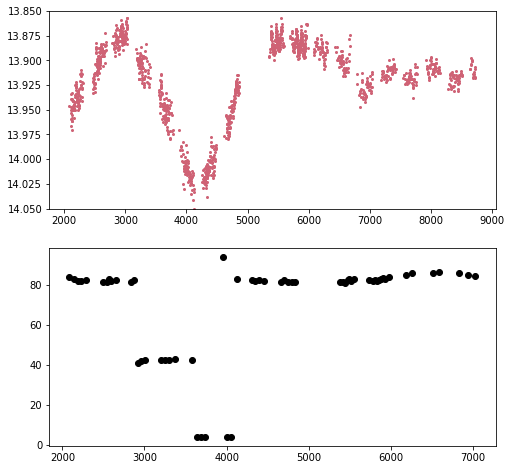

In [109]:
#plot with LC
fig,ax=plt.subplots(2,1,figsize=(8,8))
ax[0].scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=4)
ax[0].set_ylim(14.05,13.85)
ax[1].scatter(sts,bps,color='black')

In [87]:
bps = np.array(bps)
sts = np.array(sts)
filt = np.where(bps>75)

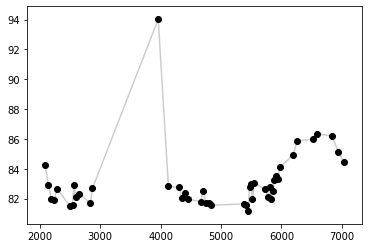

In [91]:
#zooming in: interesting pattern in rolling search
plt.plot(sts[filt],bps[filt],color='black',alpha=0.2)
plt.scatter(sts[filt],bps[filt],color='black')

# plt.ylim(75,90)

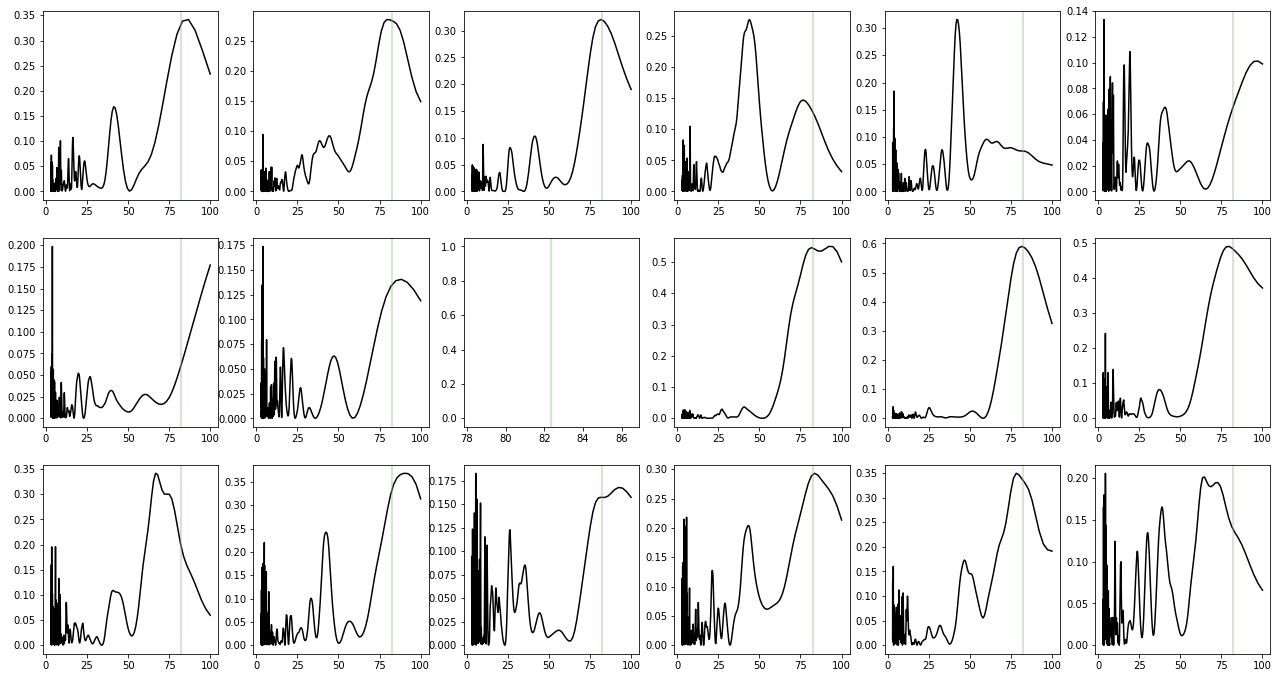

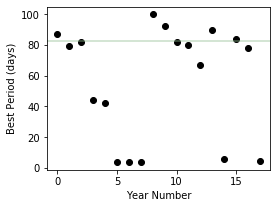

In [111]:
#by year, detrended
yrs,bps = o.yrpd(iband,minp=3,maxp=100,orb=82.37,plotbest=True,det=True,window=200,plotpd=True,spline=True,btol=50)

In [117]:
midyr = []
for y in yrs:
    end,st = y['MJD-50000'][-1],y['MJD-50000'][0]
    midyr.append(st+(end-st)/2)

by year, search is on detrended data
- next: repeat without detrending (some sort of artifact of detrending?)

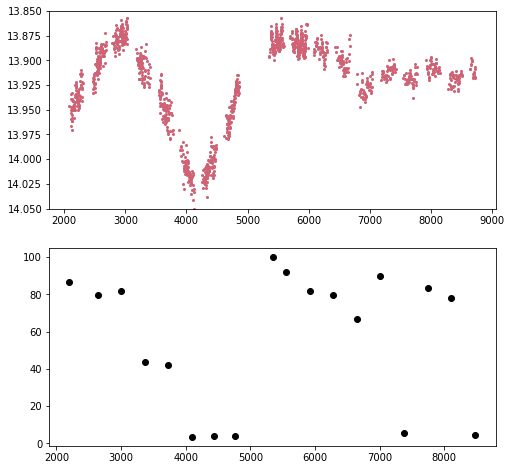

In [118]:
#plot with LC
fig,ax=plt.subplots(2,1,figsize=(8,8))
ax[0].scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=4)
ax[0].set_ylim(14.05,13.85)
ax[1].scatter(midyr,bps,color='black')


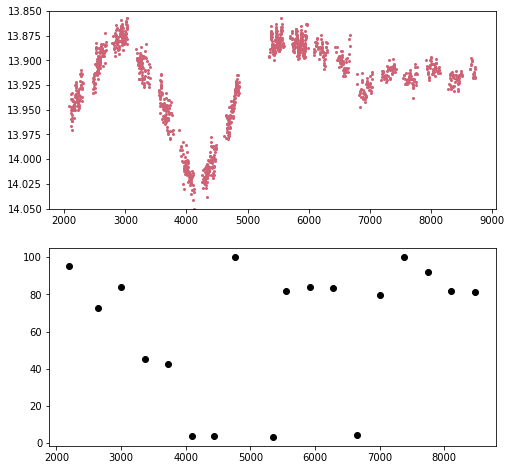

In [122]:
yrs,bps = o.yrpd(iband,minp=3,maxp=100,orb=82.37,plotbest=False,det=False,plotpd=False)
midyr = []
meanmag = []
for y in yrs:
    end,st = y['MJD-50000'][-1],y['MJD-50000'][0]
    midyr.append(st+(end-st)/2)
    meanmag.append(np.mean(y['I mag']))
fig,ax=plt.subplots(2,1,figsize=(8,8))
ax[0].scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=4)
ax[0].set_ylim(14.05,13.85)
ax[1].scatter(midyr,bps,color='black')

(14.02, 13.86)

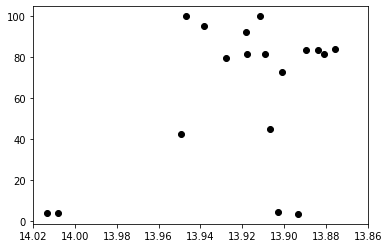

In [124]:
#more direct: plot best period vs. mean mag --> no real correlation...
plt.scatter(meanmag,bps,color='black')
plt.xlim(14.02,13.86)

possible drift, but no other obvious orbital period
- name: RX J0059.2-7138
- shape decently FRED-like with updated period of 81.9

# Source 5
- in notebook, agreed with 1.805 and 0.6425 as strong signals
- in auto (spline) analysis, ~189 days, though looks like periodogram was building up with aliases but caught off at 200 days
- and in detrended: 2.23 days
- again, super-orbital signal around 1200 days

In [185]:
summ[4:5] #spin period 4.78 days 

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,V V-I int,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part
4,5,12.91333,-72.28433,4.78,1.4,0.0,0.0,NaN,15.549296,0.044747,...,15.667252,no,0.133,NaN,-0.257503,1.181314,-0.241179,0.598523,2.23379,1.0


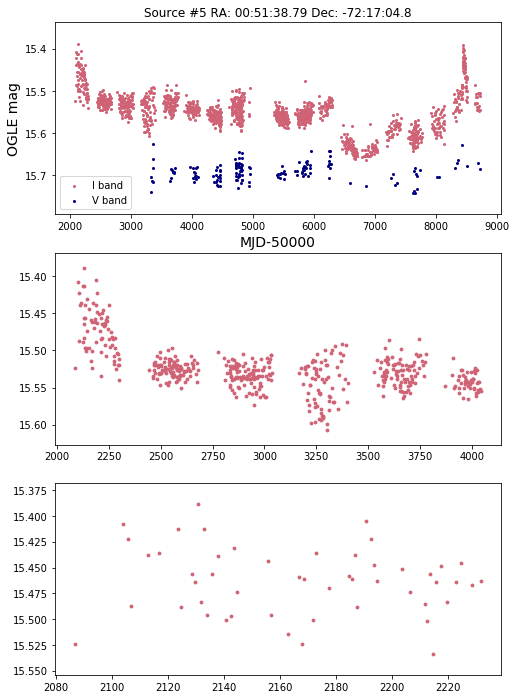

In [153]:
ilist,vlist = o.getIV(5,cross,plot=True,zooms=True,figsize=(8,12),mult=(3,8),offset=10,stack=False) 
iband,vband = vstack(ilist),vstack(vlist)
o.splinedetrend(iband,window=50)

0.390959281824122


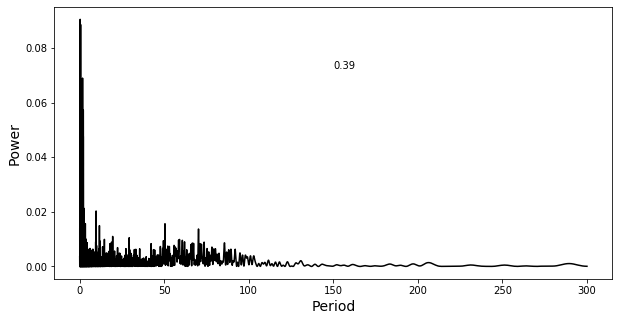

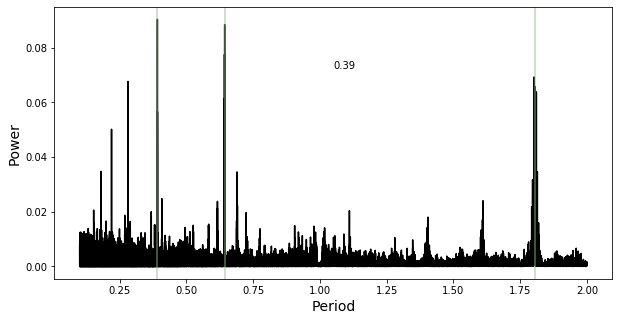

In [154]:
#broad search
o.periodogram(iband,det=True,minp=0.1,maxp=300,figsize=(10,5))

print(o.periodogram(iband,det=True,minp=0.1,maxp=2,figsize=(10,5)))
plt.axvline(0.6425,color='darkseagreen',alpha=0.6)
plt.axvline(1.805,color='darkseagreen',alpha=0.6)
plt.axvline(0.39,color='darkseagreen',alpha=0.6)

0.39 or 0.6425 could be real and beat period with sampling period of 1 day

In [157]:
findbeat(0.390959281824122,0.6425)

0.9986110415585466

In [158]:
aliasarr([0.39,0.6425,1.805]) #0.39 could be alias of 0.64 or vice versa

array([[0.63934426, 1.7972028 , 2.24223602],
       [0.28057554, 0.39117199, 0.64349376]])

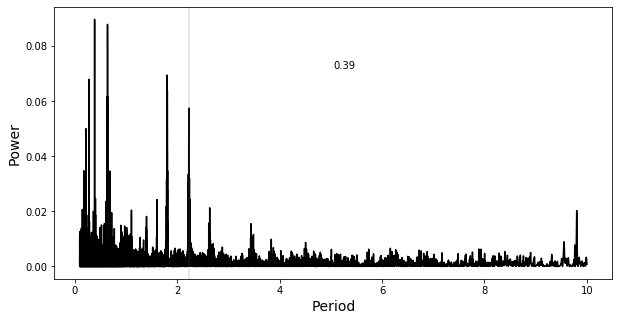

In [159]:
#check for 2.23 day result from auto -- lower than others, likely due to detrending window?
o.periodogram(iband,det=True,minp=0.1,maxp=10,figsize=(10,5))
plt.axvline(2.23,alpha=0.2)

In [121]:
#best period with different windows for rspline
for w in [50,100,200,500,700,1000]:
    o.splinedetrend(iband,window=w)
    print(o.periodogram(iband,det=True,minp=0.1,maxp=200,plot=False))

0.3909587557003123
0.3909587557003123
0.3909587557003123
0.3909587557003123
0.3909587557003123
0.3909587557003123


Text(0, 0.5, 'Best Period')

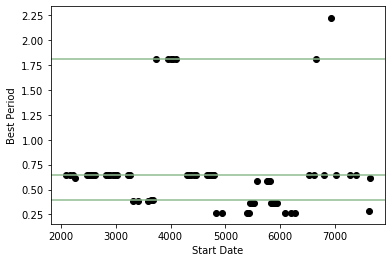

In [160]:
#rolling period
ps,pows,bps,sts = o.rollpd(iband,npoint=200,nroll=20,det=True,minp=0.1,maxp=10,plot=False)
plt.scatter(sts,bps,color='black')
plt.axhline(0.39,color='darkseagreen')
plt.axhline(0.6425,color='darkseagreen')
plt.axhline(1.805,color='darkseagreen')

plt.xlabel('Start Date')
plt.ylabel('Best Period')

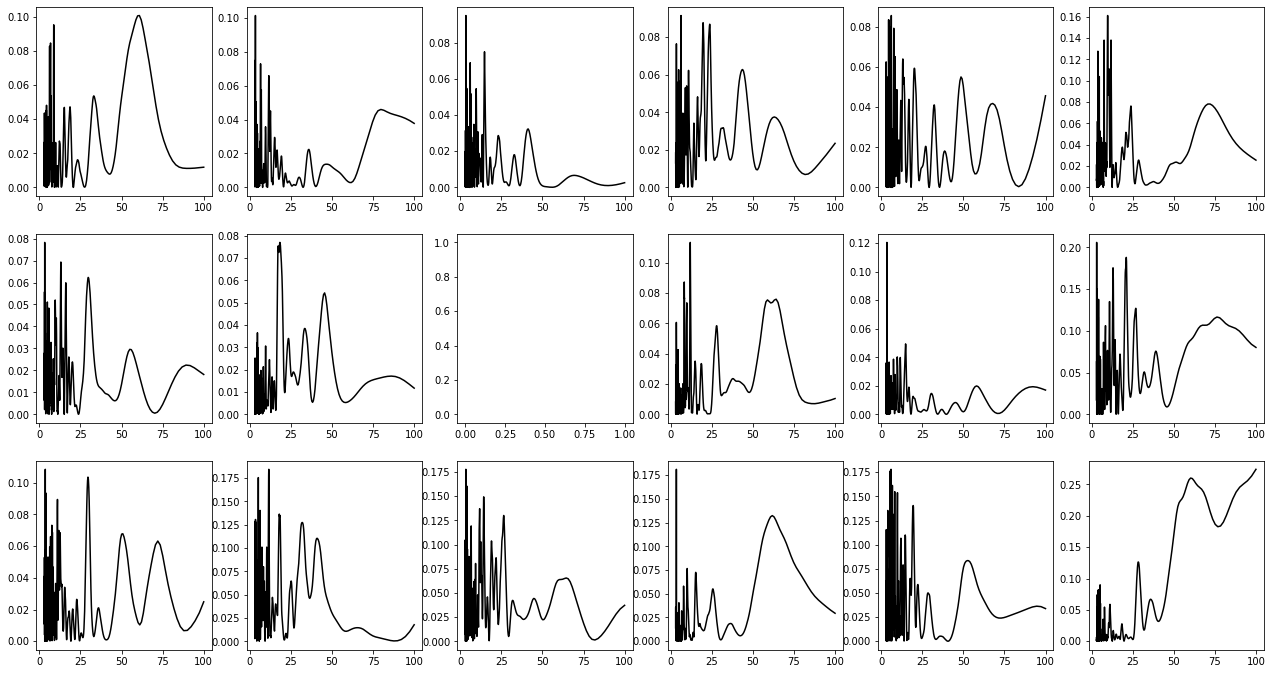

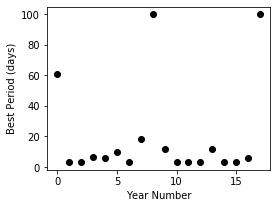

In [161]:
#period by year -- 3,6,9,18 days
yrs,bps = o.yrpd(iband,minp=3,maxp=100,plotbest=True,det=True,window=200,plotpd=True,spline=True,btol=50)

In [138]:
# for b in bps:
#     plt.figure(figsize=(3,2))
#     pd = b #from auto analysis
#     mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
#     plt.step(mid,avg,color='black',where='mid',label=f'{b:.2f}d')
#     plt.legend()

below: some good shape but look at how small the mean variations are, esp. considering the standard errors

(15.553, 15.542)

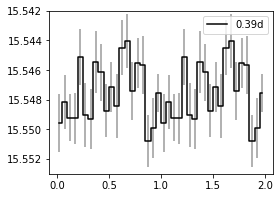

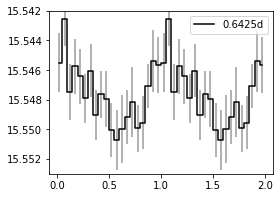

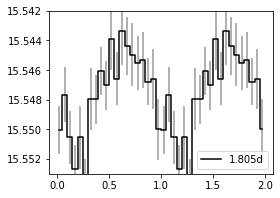

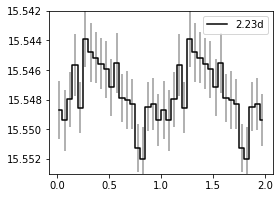

In [167]:
#phase-folding -- notice how small these deviations are
plt.figure(figsize=(4,3))
pd = 0.39 
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid',label='0.39d')
plt.legend()
# plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
# plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
mini,maxi = np.min(iband['I detrend']),np.max(iband['I detrend'])
plt.ylim(15.553,15.542)

plt.figure(figsize=(4,3))
pd = 0.6425 
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid',label='0.6425d')
plt.legend()
# plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
# plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.ylim(15.553,15.542)

plt.figure(figsize=(4,3))
pd = 1.805 
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid',label='1.805d')
# plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
# plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.legend()
plt.ylim(15.553,15.542)

plt.figure(figsize=(4,3))
pd = 2.23 #from auto analysis
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid',label='2.23d')
# plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
# plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.legend()
plt.ylim(15.553,15.542)


,period,power
120,9.800383,0.020348
11,50.535087,0.015698
97,11.768064,0.014950
2,70.340061,0.013827
55,19.600461,0.011034


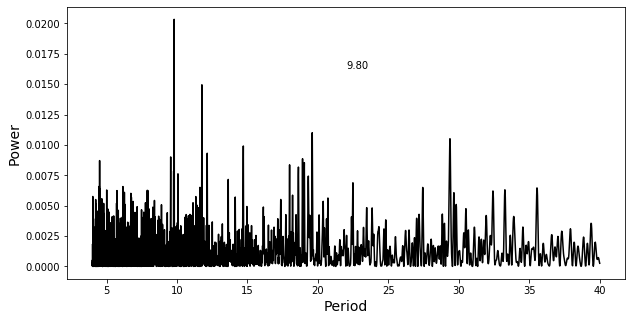

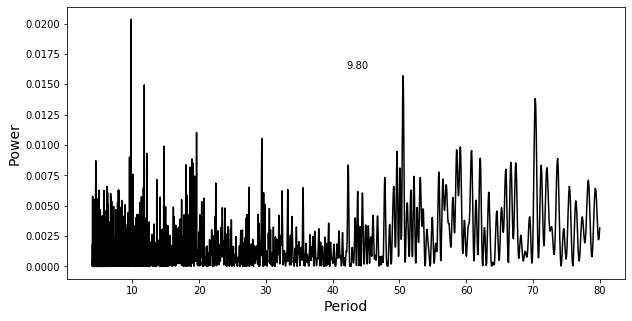

In [181]:
#broader search for orbital period
o.periodogram(iband,det=True,minp=4,maxp=40,figsize=(10,5))
freq,power,bp = o.periodogram(iband,det=True,minp=4,maxp=80,figsize=(10,5),more=True)
o.findpeaks(freq,power,pkorder=True,sigma=5)[:5]

(15.555, 15.54)

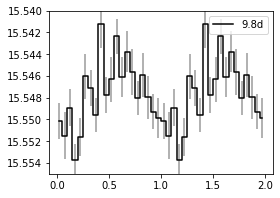

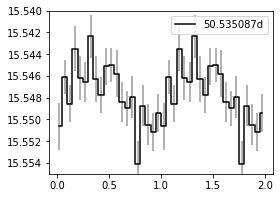

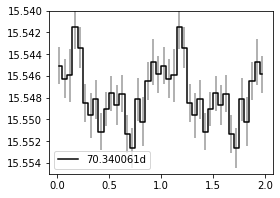

In [186]:
plt.figure(figsize=(4,3))
pd = 9.8 #from auto analysis
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid',label=f'{pd}d')
# plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
# plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.legend()
plt.ylim(15.555,15.54)

plt.figure(figsize=(4,3))
pd = 50.535087 #from auto analysis
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid',label=f'{pd}d')
# plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
# plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.legend()
plt.ylim(15.555,15.54)

plt.figure(figsize=(4,3))
pd = 70.340061 #from auto analysis
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid',label=f'{pd}d')
# plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
# plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.legend()
plt.ylim(15.555,15.54)


> source #5 summary
> - strong signals + good phase-folds with 0.6425 and 1.805 days (both from literature)
> - also 0.39 but could be beat; doesn't look as good once folded
> - above, propose possible periods to look into for orbital -- works with spin period of ~5 days and look decent in fold

# Source 6

- orbital period found to be 17.13 days with INTEGRAL
- already found that phase fold with 17.13 looks better than 17.2 (which was established period) in Source6 notebook

orbital period: 17.2


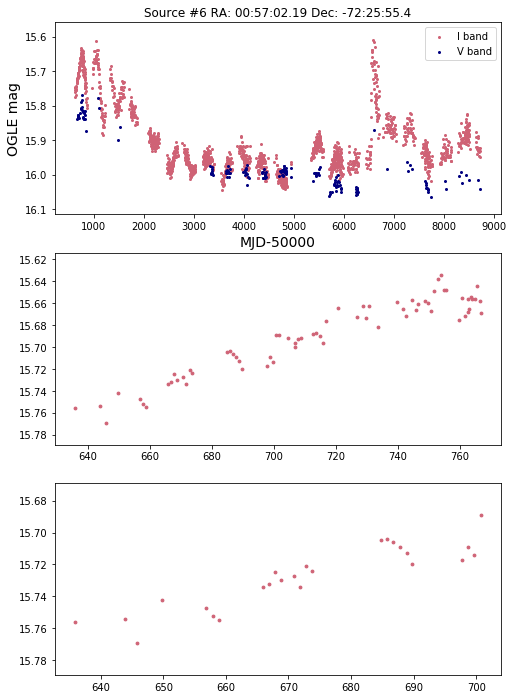

In [4]:
ilist,vlist = o.getIV(6,cross,plot=True,zooms=True,figsize=(8,12),mult=(3,8),offset=10,stack=False) 
iband,vband = vstack(ilist),vstack(vlist)
o.splinedetrend(iband,window=50)

<Quantity 17.34548376>

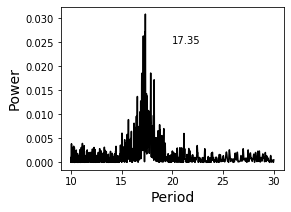

In [5]:
#as in auto analysis, periodogram with spline detrending gives 17.35
o.periodogram(iband,minp=10,maxp=30,det=True)

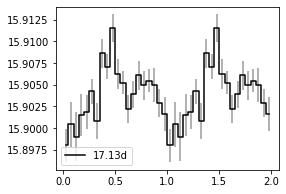

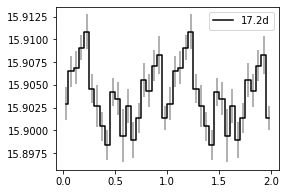

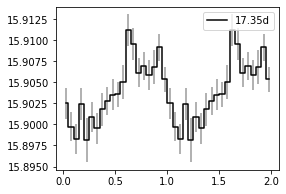

In [6]:
plt.figure(figsize=(4,3))
pd = 17.13 
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid',label=f'{pd}d')
# plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
# plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.legend()
# plt.ylim(15.555,15.54)

plt.figure(figsize=(4,3))
pd = 17.2
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid',label=f'{pd}d')
# plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
# plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.legend()
# plt.ylim(15.555,15.54)

plt.figure(figsize=(4,3))
pd = 17.35
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid',label=f'{pd}d')
# plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
# plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.legend()
# plt.ylim(15.555,15.54)

Text(0, 0.5, 'Best Period')

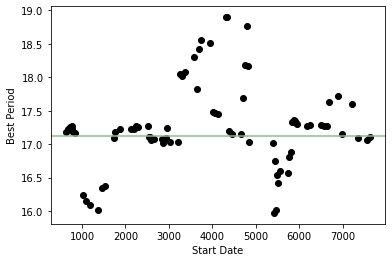

In [7]:
#rolling period
ps,pows,bps,sts = o.rollpd(iband,npoint=200,nroll=20,det=True,minp=16,maxp=19,plot=False)
plt.scatter(sts,bps,color='black')
plt.axhline(17.13,color='darkseagreen')
plt.xlabel('Start Date')
plt.ylabel('Best Period')

In [8]:
#period by year 
# yrs,bps = o.yrpd(iband,minp=16,maxp=19,plotbest=True,det=True,window=200,plotpd=True,spline=True,btol=50)

see summary about ~285 day super-orbital, potential inconsistency but hard to conclude

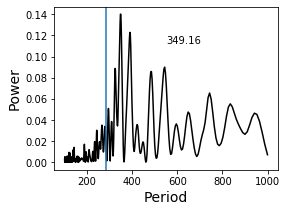

In [9]:
o.periodogram(iband,minp=100,maxp=1000)
plt.axvline(285)

In [13]:
findbeat(17.35,285)

18.474687091350646

In [14]:
aliasarr([17.13,.997,285])

array([[  1.06199628, 332.33333333,   1.00352113],
       [  0.9448428 ,   0.49924887,   0.9965035 ]])

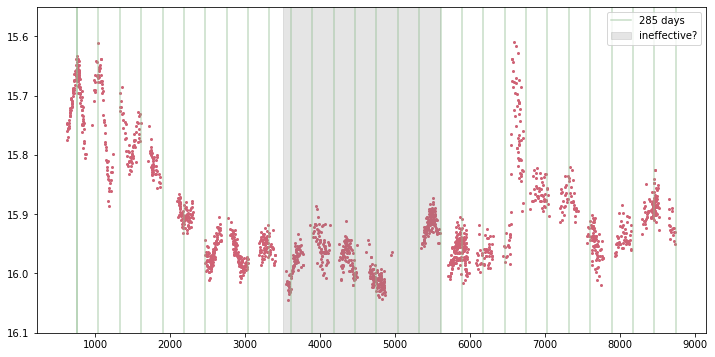

In [34]:
plt.figure(figsize=(12,6))
plt.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=4)
plt.ylim(16.1,15.55)
plt.axvline(760,color='darkseagreen',alpha=0.5,label='285 days')
for i in range(29):
    plt.axvline(760+285*i,color='darkseagreen',alpha=0.5)
plt.axvspan(3500,5600,color='grey',alpha=0.2,label='ineffective?')
plt.legend()

# Source 7
- 21.9 known through X-ray, but in Source7.ipynb agreed with recent literature giving best optical period of 24.8 days
- three epochs in super-orbital in Source7.ipynb
- here: look for orbital with spline detrending
    - auto zoom-in didn't include 24.8; best 23.96 but phase-fold not great
- **example where "best auto det pd" in summary table should be overridden**
    - not doing yet for uniformity but perhaps consider for these ten sources

orbital period: 21.9


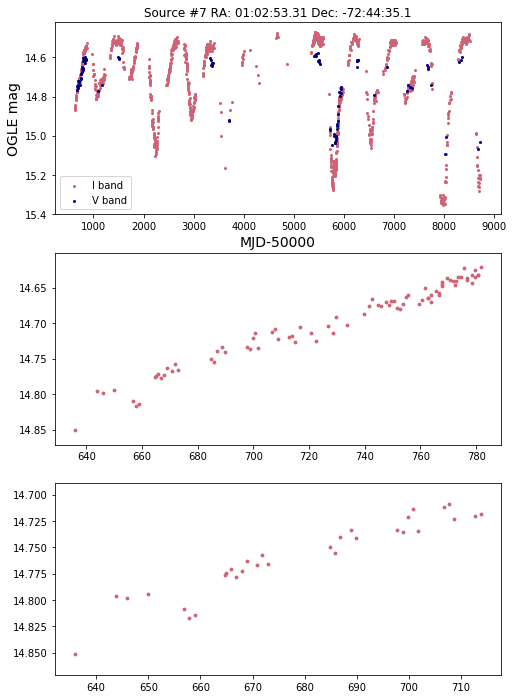

In [35]:
ilist,vlist = o.getIV(7,cross,plot=True,zooms=True,figsize=(8,12),mult=(3,8),offset=10,stack=False) 
iband,vband = vstack(ilist),vstack(vlist)
o.splinedetrend(iband,window=50)

full detrended periodogram gives 24.8 days as expected from previous analysis

<Quantity 24.7933041>

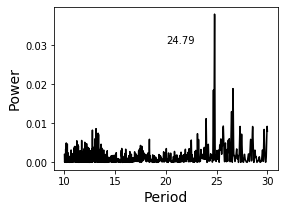

In [40]:
o.periodogram(iband,minp=10,maxp=30,det=True)
# plt.axvline(21.9,color='darkseagreen')

(14.73, 14.705)

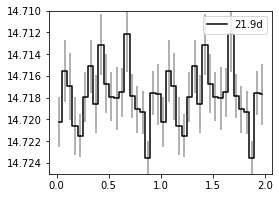

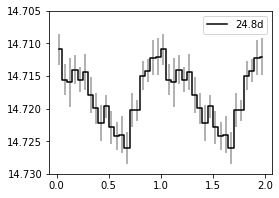

In [55]:
#fold with 21.9 and 24.8
plt.figure(figsize=(4,3))
pd = 21.9 
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid',label=f'{pd}d')
# plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
# plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.legend()
plt.ylim(14.725,14.71)

plt.figure(figsize=(4,3))
pd = 24.8
mid,avg,err = o.meanphase(iband,pd,pbins=20,det=True,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
plt.step(mid,avg,color='black',where='mid',label=f'{pd}d')
# plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
# plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
plt.legend()
plt.ylim(14.73,14.705)


In [46]:
findbeat(21.9,704) #beat with super-orbital doesn't give 24.8

22.60313736988711

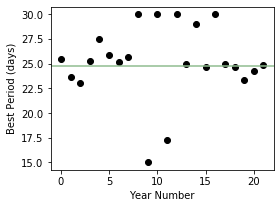

In [63]:
#search by year and rolling search to see consistency
yrs,bps = o.yrpd(iband,minp=15,maxp=30,plotbest=True,det=True,window=200,plotpd=False,spline=True,btol=50)
plt.axhline(24.8,color='darkseagreen')

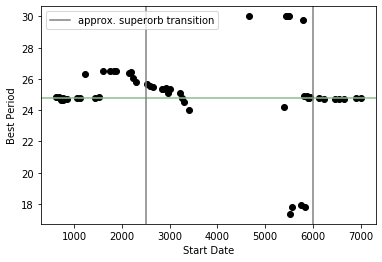

In [67]:
#some change but no clear trend; no best periods at orbital period (21.9)
ps,pows,bps,sts = o.rollpd(iband,npoint=200,nroll=20,det=True,minp=15,maxp=30,plot=False)
plt.scatter(sts,bps,color='black')
plt.axhline(24.8,color='darkseagreen')
plt.xlabel('Start Date')
plt.ylabel('Best Period')
plt.axvline(2500,color='grey',label='approx. superorb transition') #super-orbital transition
plt.axvline(6000,color='grey')
plt.legend()
#if anything, period gets weird near/leading up to transition but nothing clear

In [61]:
findbeat(24.8,704) #possible that higher periods are beat period but not clear

25.705535924617198

# Source 9
- sticking with pulsating for now so skipping 8
- agreed with established period but wasn't sure of precision
    - search again with spline detrending and compare folds

orbital period: 44.92


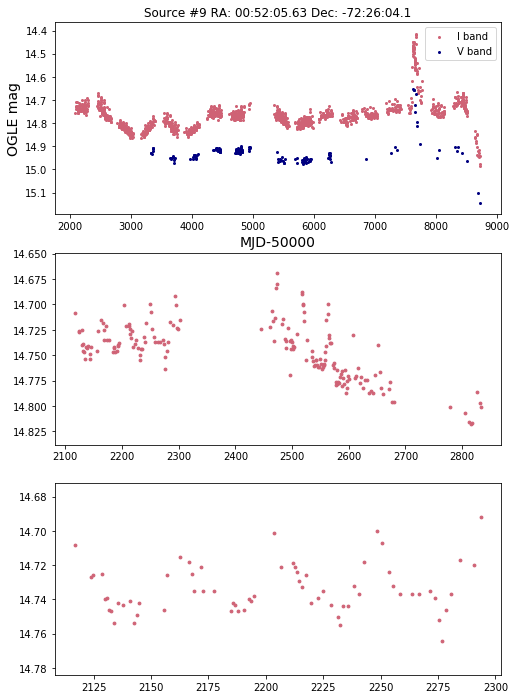

In [70]:
ilist,vlist = o.getIV(9,cross,plot=True,zooms=True,figsize=(8,12),mult=(3,8),offset=10,stack=False) 
iband,vband = vstack(ilist),vstack(vlist)
o.splinedetrend(iband,window=50)

<Quantity 44.90675375>

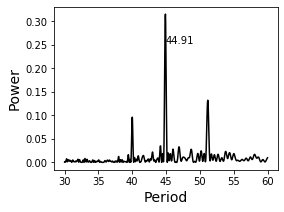

In [79]:
o.periodogram(iband,minp=30,maxp=60,det=True)#higher samples --> down to 44.90

In [93]:
def compare_fold(iband,pds,points=False,pbins=20,det=True,y=.001):
    '''Compare multiple periods by phase-folding.
    points: if True, add points
    det: if True, use detrended data (but uses detrended points either way)
    pbins: number of phase bins
    TO DO: subplots rather than separate plots'''
    for pd in pds:
        plt.figure(figsize=(4,3))
        mid,avg,err = o.meanphase(iband,pd,pbins=pbins,det=det,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
        plt.step(mid,avg,color='black',where='mid',label=f'{pd}d')
        if points:
            plt.scatter((iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
            plt.scatter(1+(iband['MJD-50000']%pd)/pd,iband['I detrend'],color=pink,s=3,alpha=0.3)
        plt.errorbar(mid,avg,yerr=err,color='black',alpha=0.4,ls='none')
        plt.legend()
        maxi,mini=np.nanmax(avg+np.nanmax(err)),np.nanmin(avg-np.nanmax(err))
        plt.ylim(maxi+y,mini-y)


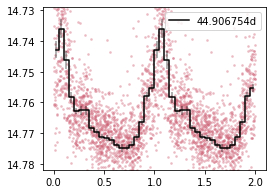

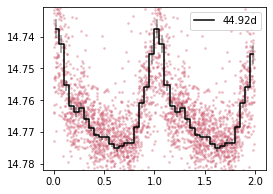

In [76]:
compare_fold(iband,[44.906754,44.92],points=True,y=.004)#basically identical, as shown in auto analysis as well

# Source 10
- SXP 7.92
- previous analysis: 39.9 days better than established 40.03
    - in auto, ~39.9 and 39.8 so try to differentiate which is better here
- didn't find pattern in super-orbital

- according to Bartlett et al. 2017, edge-on
    - negative (redder when brighter) I vs. V-I corr but positive (bluer when brighter) V V-I correlation
    - they determined it to be edge-on with H-alpha line
    - they give period 40+/-0.3 days

orbital period: 40.03


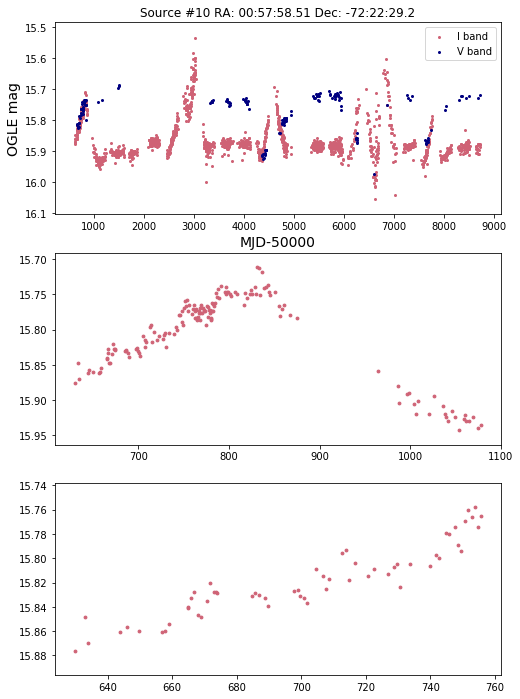

In [141]:
ilist,vlist = o.getIV(10,cross,plot=True,zooms=True,figsize=(8,12),mult=(3,8),offset=10,stack=False) 
iband,vband = vstack(ilist),vstack(vlist)
o.splinedetrend(iband,window=50)

I and V-I correlation: -0.6832617411444406
V and V-I correlation: 0.7737722449334529


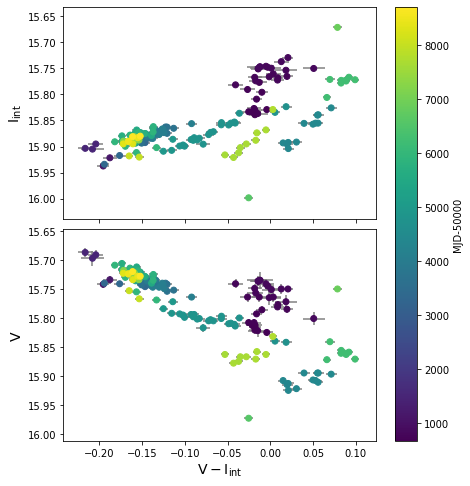

In [107]:
#show both color-mag b/c of Bartlett paper
interp = o.colormag(iband,vband) #tough b/c not much sampling around peaks (but navy from first peak)

<Quantity 39.82889267>

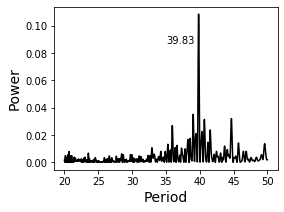

In [84]:
o.periodogram(iband,minp=20,maxp=50,det=True) #same as in auto analysis
#in auto, same result with different spline windows

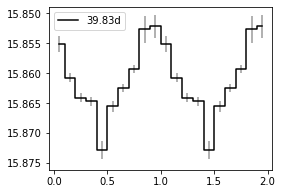

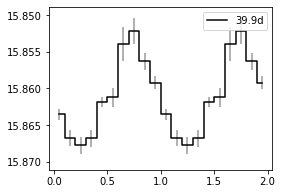

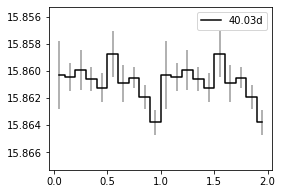

In [91]:
compare_fold(iband,[39.83,39.9,40.03],pbins=10) #tried out fewer phase bins

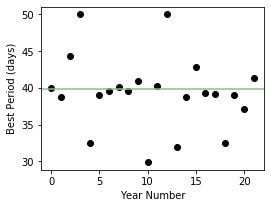

In [142]:
#by year
yrs,bps = o.yrpd(iband,minp=30,maxp=50,plotbest=True,det=True,window=200,plotpd=False,spline=True,btol=50)
plt.axhline(39.83,color='darkseagreen')

In [96]:
#fold each year 
# for y in yrs:
#     compare_fold(y,[39.9,39.83])

Text(0, 0.5, 'Best Period')

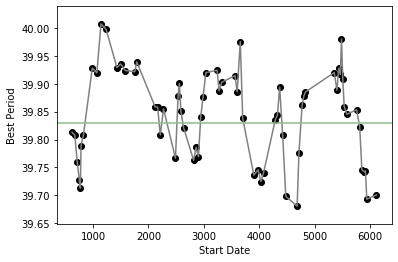

In [102]:
#rolling search
ps,pows,bps,sts = o.rollpd(iband,npoint=400,nroll=20,det=True,minp=35,maxp=45,plot=False)
plt.scatter(sts,bps,color='black')
plt.plot(sts,bps,color='grey')

plt.axhline(39.83,color='darkseagreen')
plt.xlabel('Start Date')
plt.ylabel('Best Period')
#possible pattern but hard to tell -- vary sampling

Text(0, 0.5, 'Best Period')

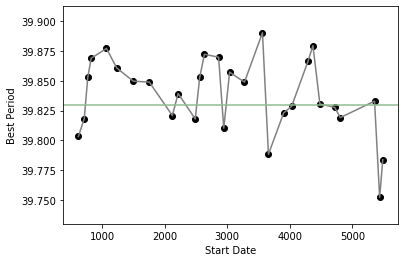

In [104]:
#different number of points and roll
ps,pows,bps,sts = o.rollpd(iband,npoint=600,nroll=40,det=True,minp=35,maxp=45,plot=False)
plt.scatter(sts,bps,color='black')
plt.plot(sts,bps,color='grey')

plt.axhline(39.83,color='darkseagreen')
plt.xlabel('Start Date')
plt.ylabel('Best Period')

In [109]:
import sklearn.utils as sk
# try out bootstrapping for error determination
test = sk.resample(np.arange(0,len(iband)))

In [111]:
ibt = iband[test]

In [113]:
test[:10]

array([1475, 1142,  573,  475,  322,  722,  765,  956,  230,  443])

In [127]:
# bps = []
# for i in range(1000):
#     #temporary iband from bootstrapping
#     tinds = sk.resample(np.arange(0,len(iband)))
#     ti = iband[tinds]
#     bp = o.periodogram(ti,minp=2,maxp=100,det=True,plot=False)
# #     print(bp)
#     bps.append(bp)

In [128]:
# np.std(bps) #if rounded to 0.009, seems like a good representation of error
#doesnt change with larger bounds on periodogram

0.008530686369622755

note that tall peak in bootstrapping changed with bounds on periodogram
- or could've been from bootstrap run possibly
- but stdev the same

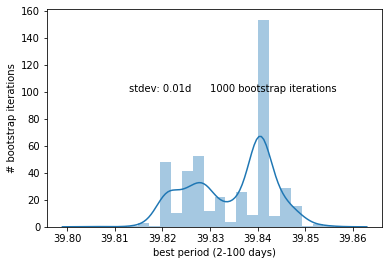

In [130]:
# sb.distplot(bps)
# plt.text(39.813,100,'stdev: 0.01d')
# plt.text(39.83,100,'1000 bootstrap iterations')
# plt.ylabel('# bootstrap iterations')
# plt.xlabel('best period (2-100 days)')
# plt.savefig('Figs/Source10bootsrap.png',dpi=200,bbox_inches='tight')

Text(0.5, 0, 'best period (30-50 days)')

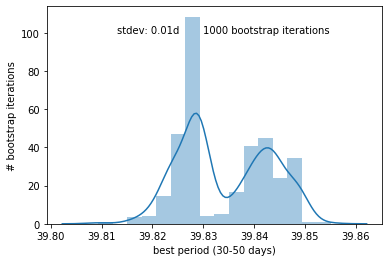

In [126]:
# sb.distplot(bps)
# plt.text(39.813,100,'stdev: 0.01d')
# plt.text(39.83,100,'1000 bootstrap iterations')
# plt.ylabel('# bootstrap iterations')
# plt.xlabel('best period (30-50 days)')

# Source 11
- first analysis: pretty inconsistent period results; some 28 day, but can't conclude
- some ~1000 day separation in super-orbital but complicated by the secondary peak (and then note the flattening at the end)
- multiple components to color-mag
- auto analysis with spline detrending gave 28.49 days = good sign

orbital period: 28.51


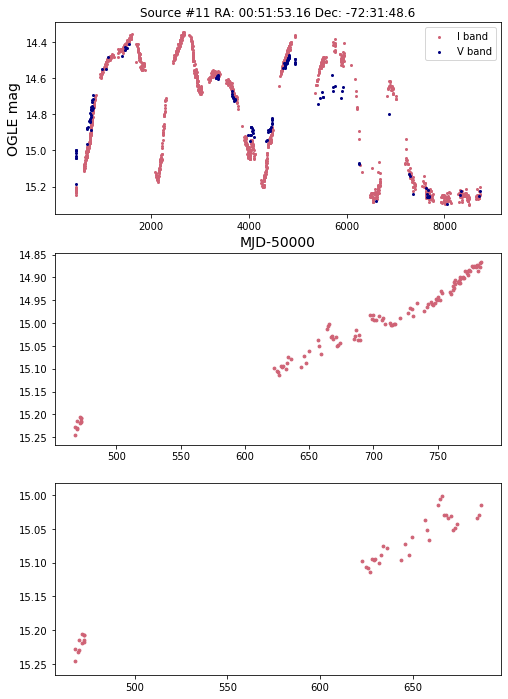

In [146]:
ilist,vlist = o.getIV(11,cross,plot=True,zooms=True,figsize=(8,12),mult=(3,8),offset=10,stack=False) 
iband,vband = vstack(ilist),vstack(vlist)
o.splinedetrend(iband,window=50)

<Quantity 1.00000034>

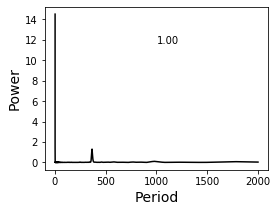

In [162]:
#window function
o.periodogram(iband,minp=1,maxp=2000,wfunc=True)

<Quantity 28.49370824>

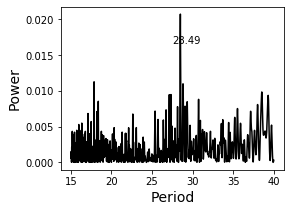

In [147]:
o.periodogram(iband,minp=15,maxp=40,det=True)

<Quantity 28.49348882>

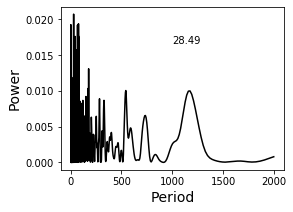

In [148]:
#larger search still gives orbital peak and wide flare ~1200 days
o.periodogram(iband,minp=1,maxp=2000,det=True)

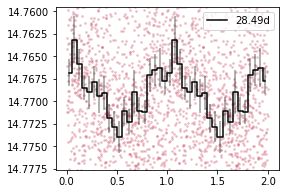

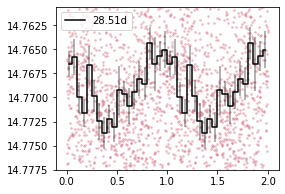

In [150]:
compare_fold(iband,[28.49,28.51],points=True) #28.49 potentially slightly better

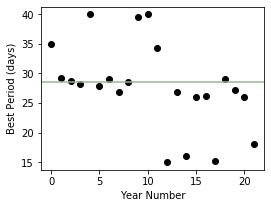

In [152]:
#search by year
yrs,bps = o.yrpd(iband,minp=15,maxp=40,plotbest=True,det=True,plotpd=False,spline=True)
plt.axhline(28.49,color='darkseagreen')

Text(0, 0.5, 'Best Period')

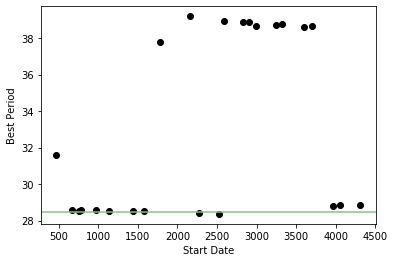

In [157]:
#rolling search
ps,pows,bps,sts = o.rollpd(iband,npoint=600,nroll=40,det=True,minp=15,maxp=40,plot=False)
plt.scatter(sts,bps,color='black')
# plt.plot(sts,bps,color='grey')

plt.axhline(28.49,color='darkseagreen')
plt.xlabel('Start Date')
plt.ylabel('Best Period')

In [170]:
#bootstrapping -- turn into function
def bootsearch(num,minp=2,maxp=100,det=True,plothist=True,printstd=True):
    bps = []
    for i in range(num):
        #temporary iband from bootstrapping
        tinds = sk.resample(np.arange(0,len(iband)))
        ti = iband[tinds]
        bp = o.periodogram(ti,minp=minp,maxp=maxp,det=det,plot=False)
        bps.append(float(bp))
    if printstd: print(f'stdev: {np.std(bps)}')
    if plothist:
        sb.distplot(bps)
    return bps

stdev: 0.693091070712531


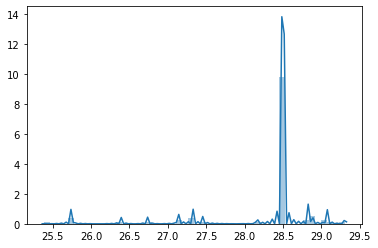

In [171]:
#larger bounds not really successful
#question is what error you want to quantify -- that of specific peak or general?
bps = bootsearch(100,minp=25,maxp=30)

In [174]:
print(f'median best period: {np.median(bps)}')
print(f'mean best period: {np.mean(bps)}') #too dependent on search criteria

median best period: 28.499327943856127
mean best period: 28.31632289811107


# Source 12
- no previous specific investigation
- auto analysis: disagreement with established period but decent fold a few days away

In [188]:
summ[11:12]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,V V-I int,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part
11,12,12.327084,-73.20028,9.13,40.0,77.2,0.0,NaN,16.229427,0.084721,...,16.572401,NaN,NaN,NaN,-0.287022,-0.348482,-1.02316,0.850715,80.847781,1.0


orbital period: 77.2


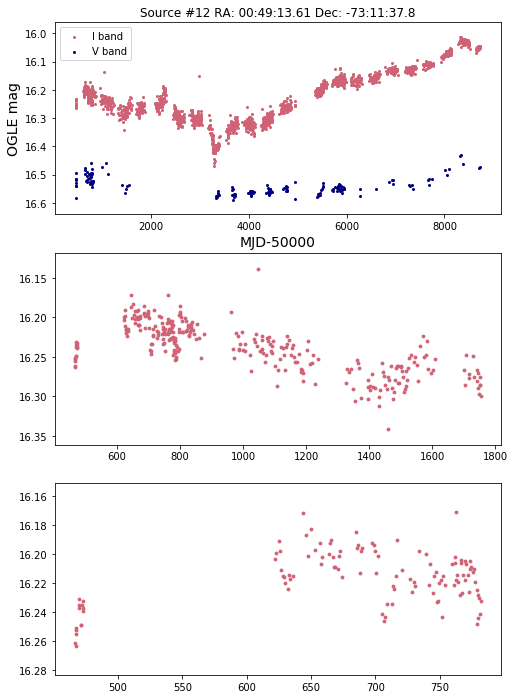

In [175]:
ilist,vlist = o.getIV(12,cross,plot=True,zooms=True,figsize=(8,12),mult=(3,8),offset=10,stack=False) 
iband,vband = vstack(ilist),vstack(vlist)
o.splinedetrend(iband,window=50)

<Quantity 182.34228988>

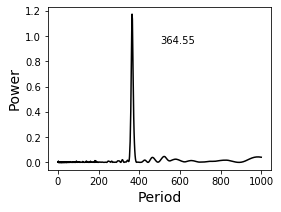

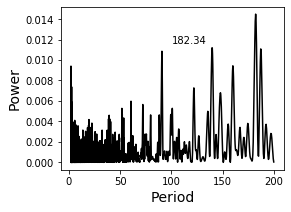

In [178]:
#window function (not including at 1 day)
o.periodogram(iband,minp=2,maxp=1000,wfunc=True) #keep this peak in mind when looking for super-orbital
#not including 364 day peak
o.periodogram(iband,minp=2,maxp=200,wfunc=True)

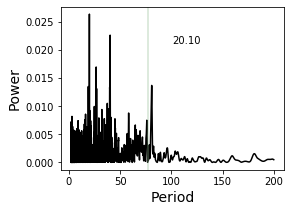

In [181]:
o.periodogram(iband,minp=2,maxp=200,det=True)
plt.axvline(77.2,color='darkseagreen',alpha=0.4)

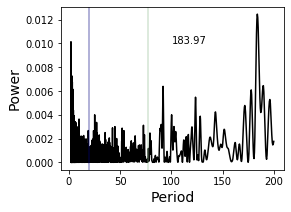

In [192]:
#search without detrending
o.periodogram(iband,minp=2,maxp=200,det=False)
plt.axvline(77.2,color='darkseagreen',alpha=0.4)
plt.axvline(20.1,color='navy',alpha=0.4)

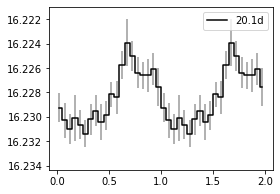

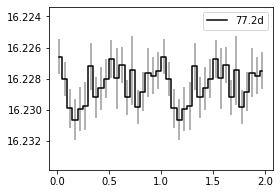

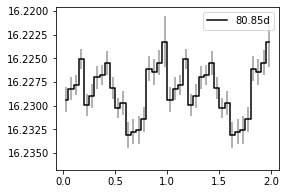

In [203]:
compare_fold(iband,[20.1,77.2,80.85])

no period looks good without detrending

In [201]:
20.1*4

80.4

In [195]:
for w in range(50,1000,100):
    o.splinedetrend(iband,window=w)
    print(o.periodogram(iband,minp=2,maxp=200,det=True,plot=False))
#still 20.1 best period with different spline detrending windows

20.095055324307896
20.099944560941513
20.099944560941513
20.099944560941513
20.099944560941513
20.099944560941513
20.099944560941513
20.099944560941513
20.099944560941513
20.099944560941513


In [198]:
o.splinedetrend(iband,window=50)

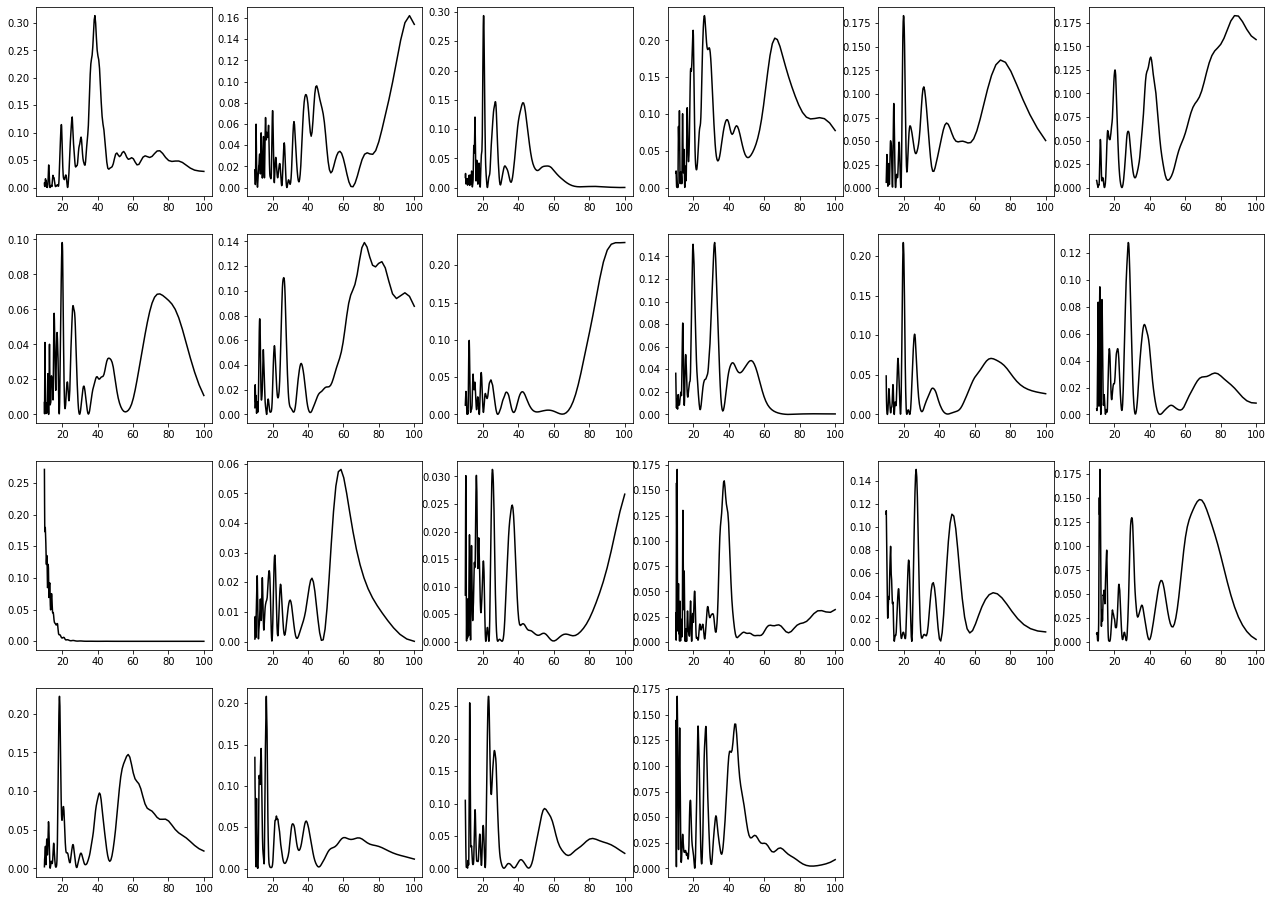

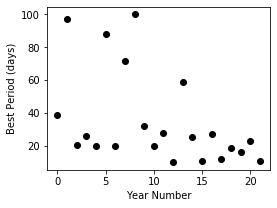

In [199]:
#search by year and show periodograms
yrs,bps = o.yrpd(iband,minp=10,maxp=100,plotbest=True,det=True,plotpd=True,spline=True)

peaks around 77 always wide

Text(0, 0.5, 'Best Period')

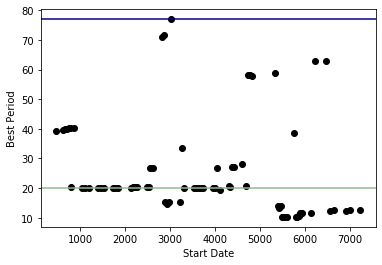

In [200]:
#rolling search
ps,pows,bps,sts = o.rollpd(iband,npoint=200,nroll=20,det=True,minp=10,maxp=100,plot=False)
plt.scatter(sts,bps,color='black')
# plt.plot(sts,bps,color='grey')

plt.axhline(20.1,color='darkseagreen')
plt.axhline(77.2,color='navy')

plt.xlabel('Start Date')
plt.ylabel('Best Period')

**not sure of source for 77.2 days (X-ray?) but strongest, most consistent signal at ~20.1 days**

stdev: 10.532587868516808


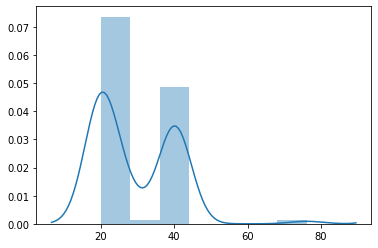

In [206]:
bps = bootsearch(100,minp=2,maxp=200)

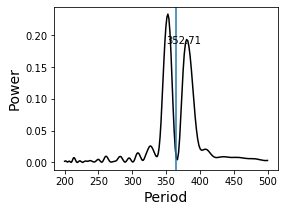

In [212]:
#lastly, look at super-orbita
o.periodogram(iband,minp=200,maxp=500)
plt.axvline(364) #peaks split around peak from window function

no clear trend in full LC

# Update Summary Table
- something like a "checked period" or existing column for best period
- info about super-orbital, other categorical